## Importing libraries

In [23]:
import os
import tensorflow as tf
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Model
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.applications.xception import preprocess_input
import cv2
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers, models, optimizers
from PIL import Image, ImageOps
from sklearn.model_selection import train_test_split

## Reading data

In [24]:
def load_dataset(image_dir, gt_dir, target_size=(224, 224)):
    X = []
    y = []
    c = 0
    image_files = [f for f in os.listdir(image_dir) if f.endswith('.jpg')]
    image_files.sort()  # opcjonalnie

    if not image_files:
        raise ValueError("Brak plików .jpg w podanym katalogu!")

    for img_file in image_files:
        img_path = os.path.join(image_dir, img_file)
        mat_path = os.path.join(gt_dir, 'GT_' + img_file.replace('.jpg', '.mat'))

        # Wczytaj i przeskaluj obraz do dokładnego rozmiaru target_size (bez paddingu)
        img = Image.open(img_path).convert('RGB')
        img_resized = img.resize(target_size, Image.LANCZOS)

        # Konwersja do numpy + preprocess_input (dla MobileNet)
        img_array = np.array(img_resized, dtype=np.float32)
        img_array = preprocess_input(img_array)

        # Wczytaj ground truth (liczba osób)
        mat = scipy.io.loadmat(mat_path)
        count = len(mat['image_info'][0][0][0][0][0])

        X.append(img_array)
        y.append(count)
        # if c == 1:
        #     plt.imshow(img_resized)
        #     print(img_path)
        #     print(count)
        #     break
        # c += 1

    return np.array(X), np.array(y)

## Getting the training set and the test set

In [4]:
X_train, y_train = load_dataset('ShanghaiTech/part_B/train_data/images/', 'ShanghaiTech/part_B/train_data/ground-truth/')

In [5]:
X_test, y_test = load_dataset('ShanghaiTech/part_B/test_data/images/', 'ShanghaiTech/part_B/test_data/ground-truth/')

## Building the model

In [25]:
# Load pre-trained model without top classifier layers
base_model = Xception(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze base model

model = models.Sequential([
    base_model,
    layers.Flatten(),
    layers.Dropout(0.3),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='linear')
])

model.compile(optimizer=Adam(1e-4), loss='mse', metrics=['mae'])

## Data augmentation and training the model

In [26]:
# Function to augment
data_augmentation = tf.keras.Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.1),
    RandomZoom(0.1),
])

def augment(x, y):
    return data_augmentation(x), y

training_set = tf.data.Dataset.from_tensor_slices((X_train, y_train))
training_set = training_set.map(augment)  # augment
training_set = training_set.batch(32).prefetch(tf.data.AUTOTUNE)
history = model.fit(training_set, batch_size=32,
    epochs=20, shuffle=True, validation_data=(X_test, y_test)
)

Epoch 1/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 135s 9s/step - loss: 20136.8379 - mae: 106.9293 - val_loss: 9970.1270 - val_mae: 71.3678
Epoch 2/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 112s 9s/step - loss: 10094.2256 - mae: 77.4043 - val_loss: 9254.8975 - val_mae: 73.0319
Epoch 3/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 112s 9s/step - loss: 9508.4355 - mae: 73.5863 - val_loss: 9181.5049 - val_mae: 65.6120
Epoch 4/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 143s 9s/step - loss: 8949.8994 - mae: 68.4344 - val_loss: 8600.8896 - val_mae: 63.1084
Epoch 5/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 112s 9s/step - loss: 8000.0635 - mae: 63.4697 - val_loss: 8015.7554 - val_mae: 60.8802
Epoch 6/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 122s 10s/step - loss: 7731.8643 - mae: 63.5652 - val_loss: 7862.2002 - val_mae: 57.8320
Epoch 7/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 111s 9s/step - loss: 7479.7441 - mae: 62.4747 - val_loss: 7640.0239 - val_mae: 56.1179
Epoch 8/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 143s 9s/step - loss: 7234.0034 - mae: 60.2738 - val_loss: 7119.7183 - val_mae: 54.7

## Training curves visualisation

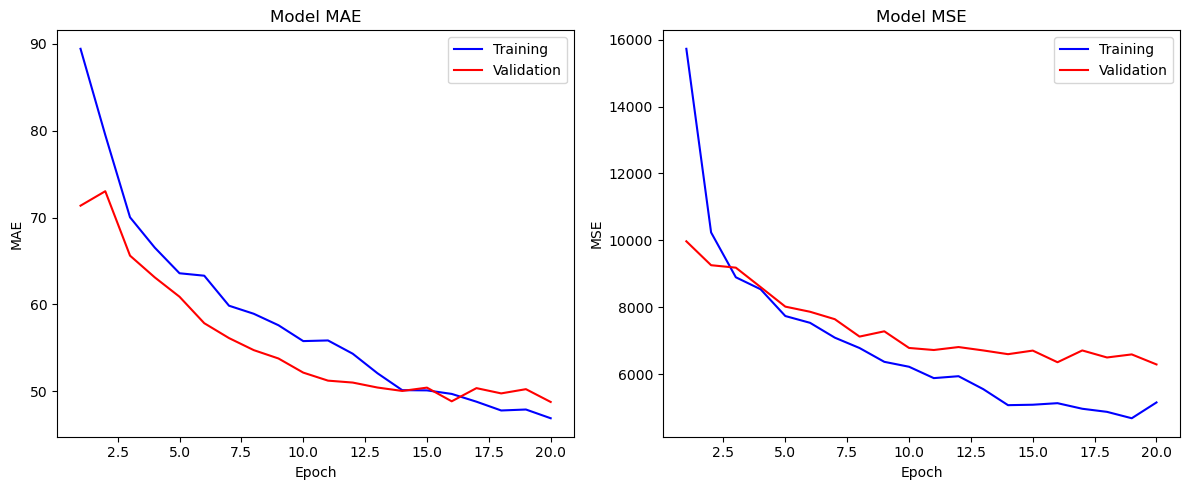

In [27]:
history_dict = history.history

# Getting the metrics
mae = history_dict['mae']
val_mae = history_dict.get('val_mae')
loss = history_dict['loss']
val_loss = history_dict.get('val_loss')

epochs = range(1, len(mae) + 1)

# MAE
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, mae, 'b-', label='Training')
if val_mae:
    plt.plot(epochs, val_mae, 'r-', label='Validation')
plt.title('Model MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

# Loss (MSE)
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'b-', label='Training')
if val_loss:
    plt.plot(epochs, val_loss, 'r-', label='Validation')
plt.title('Model MSE')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()

plt.tight_layout()
plt.show()

## Making predictions

In [28]:
y_pred = np.round(model.predict(X_test))

10/10 ━━━━━━━━━━━━━━━━━━━━ 65s 6s/step  


In [29]:
y_pred.reshape(len(y_pred), 1)
y_test.reshape(len(y_test), 1)
print(np.concatenate((y_pred.reshape(len(y_pred), 1), y_test.reshape(len(y_test), 1)), 1))

[[ 18.  23.]
 [109. 181.]
 [142. 157.]
 [ 30.  37.]
 [143.  70.]
 [ 93.  57.]
 [ 20.  44.]
 [170. 227.]
 [124. 165.]
 [154. 476.]
 [101. 139.]
 [156. 316.]
 [141. 164.]
 [ 96. 110.]
 [ 31.  20.]
 [104. 131.]
 [ 37.  48.]
 [154. 183.]
 [101. 101.]
 [196. 204.]
 [ 57.  40.]
 [ 74. 143.]
 [ 96. 146.]
 [144. 513.]
 [ 55.  70.]
 [ 81. 175.]
 [ 38.  51.]
 [ 78.  55.]
 [ 92.  67.]
 [ 93.  72.]
 [ 34.  56.]
 [117. 165.]
 [ 14.  32.]
 [ 83. 149.]
 [ 88.  48.]
 [ 64.  80.]
 [ 79. 117.]
 [ 53. 162.]
 [118. 137.]
 [128. 120.]
 [118.  72.]
 [127. 122.]
 [ 97. 198.]
 [ 58. 133.]
 [ 89. 147.]
 [ 49.  29.]
 [ 16.  70.]
 [ 32.  35.]
 [ 16.  24.]
 [146. 251.]
 [ 87.  59.]
 [ 90.  67.]
 [ 51.  61.]
 [148. 248.]
 [178. 252.]
 [147. 147.]
 [ 39.  57.]
 [101. 121.]
 [ 12.  47.]
 [209. 505.]
 [177. 297.]
 [183. 465.]
 [125. 167.]
 [ 53.  43.]
 [ 22.  46.]
 [ 99.  91.]
 [118. 263.]
 [ 58.  92.]
 [128. 117.]
 [ 37.  48.]
 [ 80.  54.]
 [ 85.  73.]
 [123. 122.]
 [104.  60.]
 [165. 170.]
 [ 41. 167.]
 [ 19.  57.]

## R2 score

In [30]:
from sklearn.metrics import r2_score
r2_score(y_test, y_pred)

0.30575889348983765